In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import bioframe
from pybedtools import BedTool as pbt
import bbi
import cooler
import cooltools

### 1. Study general properties

In [4]:
window = 120
map_size = 15
boundaries_plus = pd.read_csv(f"../data/boundaries_plus_maps_112022_{map_size}_{window}kb_params.bed" , sep = "\t", header = None)
boundaries_minus = pd.read_csv(f"../data/boundaries_minus_maps_112022_{map_size}_{window}kb_params.bed", sep = "\t", header = None)

In [60]:
boundaries_plus["border_num1"]= range(1,boundaries_plus.shape[0] + 1)
boundaries_minus["border_num2"]= range(1,boundaries_minus.shape[0] + 1)

boundaries_minus_sploped = pbt.from_dataframe(boundaries_minus).slop(b=22_500, g="../data/chrom.sizes")
boundaries_plus_sploped = pbt.from_dataframe(boundaries_plus).slop(b=22_500, g="../data/chrom.sizes")

In [63]:
boundaries_common_15kb_120kb_params = boundaries_plus_sploped.intersect(boundaries_minus_sploped, wb=True)
print(boundaries_common_15kb_120kb_params.count())
colnames = ['chrom1', 'start1', 'end1', 'bnd_strength_neurons', "log2_IS_neurons", "border_num1"] + ['chrom2', 'start2', 'end2', 'bnd_strength_glia', "log2_IS_glia", "border_num2"]
boundaries_common_15kb_120kb_params = pd.read_table(boundaries_common_15kb_120kb_params.fn, header = None, names=colnames)

4006


In [64]:
boundaries_plus_15kb_120kb_params = boundaries_plus_sploped\
                                .intersect(boundaries_minus_sploped, v=True)
boundaries_plus_15kb_120kb_params = pd.read_table(boundaries_plus_15kb_120kb_params.fn, header = None, names=['chrom1', 'start1', 'end1', 'bnd_strength_neurons', "log2_IS_neurons", "border_num1"])
boundaries_minus_15kb_120kb_params = boundaries_minus_sploped\
                                .intersect(boundaries_plus_sploped, v=True)
boundaries_minus_15kb_120kb_params = pd.read_table(boundaries_minus_15kb_120kb_params.fn, header = None, names=['chrom2', 'start2', 'end2', 'bnd_strength_glia', "log2_IS_glia", "border_num2"])   

In [65]:
boundaries_plus_15kb_120kb_params["end1_unslope"] = boundaries_plus_15kb_120kb_params["end1"] - 22_500
boundaries_plus_15kb_120kb_params["start1_unslope"] = boundaries_plus_15kb_120kb_params["start1"] + 22_500

In [66]:
path_to_maps = '../data' #set path to merged maps
resolution = 15000

hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

clr_HC_minus = cooler.Cooler(f'{path_to_maps}/NeuNminus.sampled.1000.mcool::/resolutions/{resolution}')
clr_HC_plus = cooler.Cooler(f'{path_to_maps}/NeuNplus.sampled.1000.mcool::/resolutions/{resolution}')
exp_minus = cooltools.expected_cis(clr_HC_minus, view_df=hg38_arms, nproc=15)
exp_plus = cooltools.expected_cis(clr_HC_plus, view_df=hg38_arms, nproc=15)
clrs = [clr_HC_plus, clr_HC_minus]
exps = [exp_plus, exp_minus]

clrs_15 = clrs
exps_15 = exps

In [67]:
files = [boundaries_plus, boundaries_minus]
stasks_tad_boder_all_identified = []
for i, file in enumerate(files):
    file = file.iloc[:, [0,1,2]]
    file.columns = ["chrom","start","end"]   
    stack = cooltools.pileup(clrs[i], 
                            file,
                         hg38_arms, 
                         expected_df=exps[i], 
                         flank = 120_000,
                         nproc=15)
    stack[:, :, np.all(stack == 0, axis=(0,1))] = np.nan
    stack = np.nanmean(stack, axis=0)  
    stasks_tad_boder_all_identified.append(stack)
# stacks_new_15kb_120kb_params[name] = stacks_list
num = [i.shape[0] for i in files]

In [68]:
def preprocess_data(data):
    data[data == np.inf] = np.nan
    return np.log(data)

def configure_ax(ax, title, xticks=True, yticks=True):
    ax.set_title(title)
    if not yticks:
        ax.set_yticks([])
    if not xticks:
        ax.set_xticks([])
    if xticks:
        ax.set_xticks([0, 17//2, 17-1])
        ax.set_xticklabels(["-120kb", "0", "120kb"], rotation=0)

def plot_heatmap(ax, data, cmap, vmin, vmax):
    return ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)

def plot_colorbar(fig, im, ax):
    cbar = fig.colorbar(im, cax=ax)
    ax.set_box_aspect(10)
    return cbar

def plot_3fig(file):
    sns.set_style("ticks")
    plt.rcParams['axes.facecolor'] = 'white'
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 8), dpi=450, 
                            gridspec_kw={'width_ratios': [1, 1, 0.1, 1, 0.1]})

    for i, title in zip(range(2), ['Average TAD border, NeuN+', 'Average TAD border, NeuN-']):
        data = preprocess_data(file[i])
        im = plot_heatmap(axs[i], data, cmap='coolwarm', vmin=-0.6, vmax=0.6)
        configure_ax(axs[i], title, xticks=True, yticks=False)

    plot_colorbar(fig, im, axs[2])
    axs[2].set_ylabel("log2(mean intensity)")
    data = preprocess_data(file[0] / file[1])
    im = plot_heatmap(axs[3], data, cmap='coolwarm', vmin=-0.15, vmax=0.15)
    configure_ax(axs[3], 'Average TAD border, NeuN+ / NeuN-', xticks=False, yticks=False)
    plot_colorbar(fig, im, axs[4])
    axs[4].set_ylabel("log2(mean intensity)")
    plt.tight_layout()


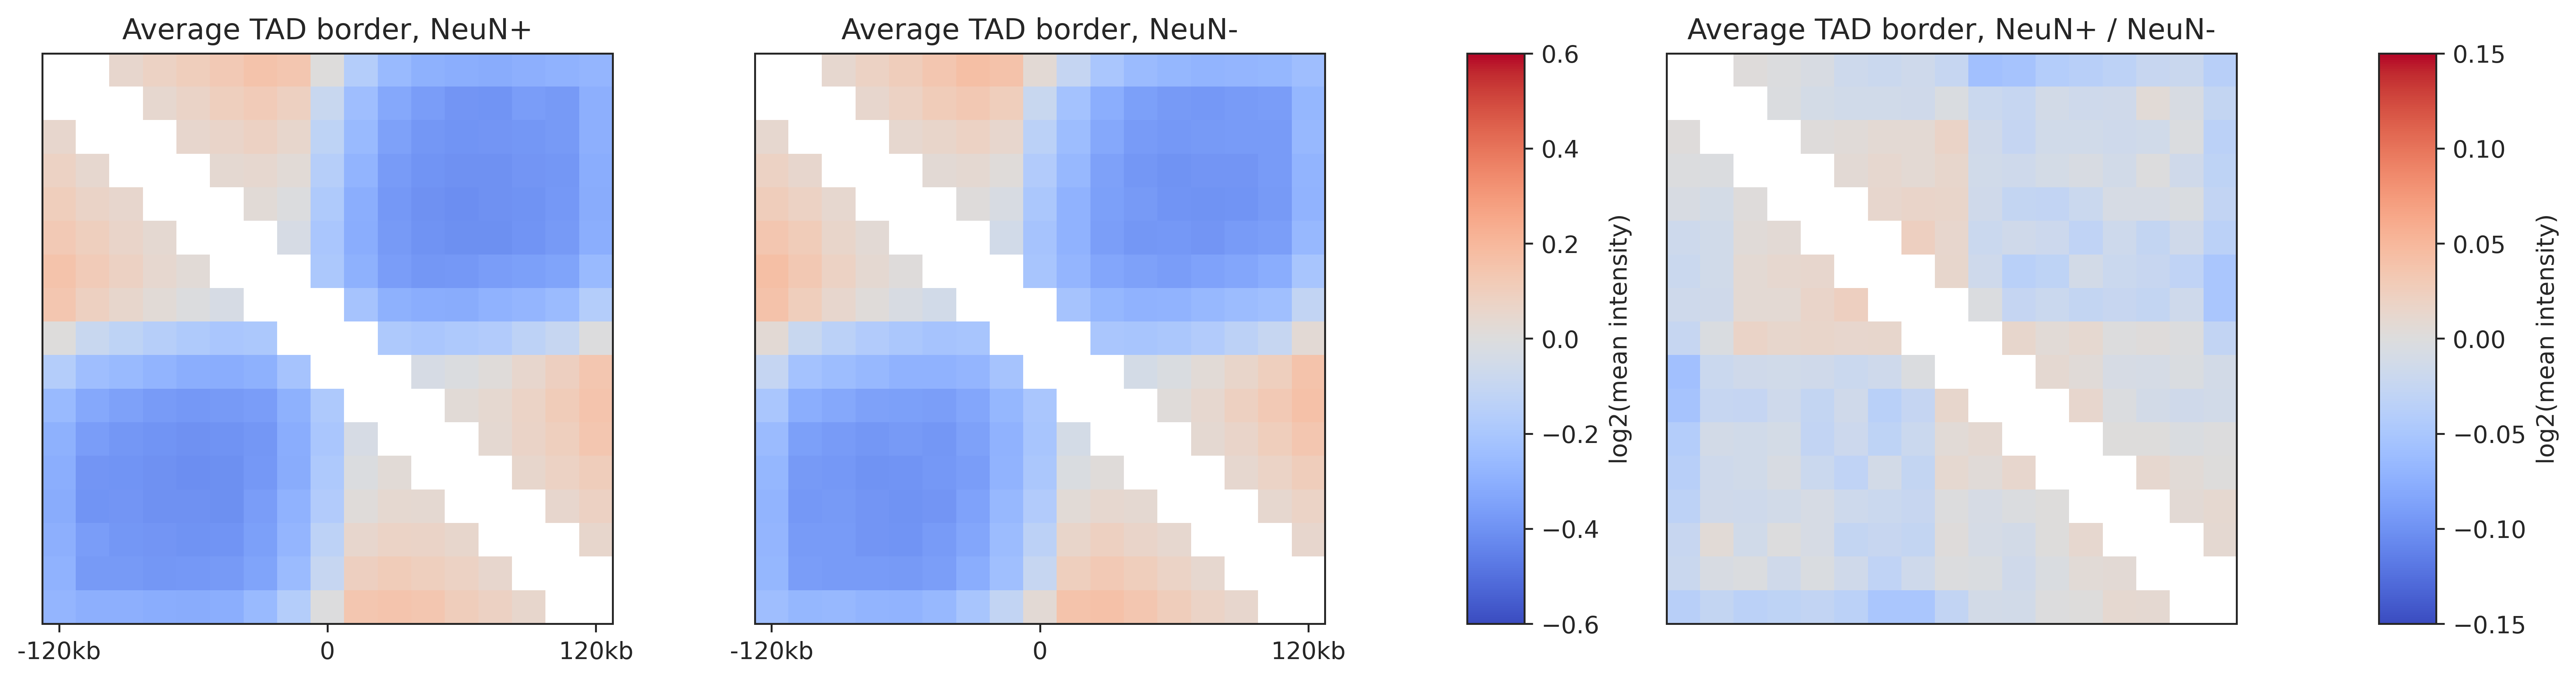

In [31]:
plot_3fig(stasks_tad_boder_all_identified)

### 2. Select cell-specific borders

In [66]:
boundaries_common_15kb_120kb_params["bnd_strength_ratio"] = boundaries_common_15kb_120kb_params["bnd_strength_neurons"] - boundaries_common_15kb_120kb_params["bnd_strength_glia"]

In [67]:
groups = np.quantile(boundaries_common_15kb_120kb_params["bnd_strength_ratio"], [0,0.23,0.5,0.77,1])
tad_groups = []
for item in boundaries_common_15kb_120kb_params["bnd_strength_ratio"]:
    if item <=groups[1]:
        tad_groups.append(0)
    if item <=groups[2] and item > groups[1]:
        tad_groups.append(1)
    if item <=groups[3] and item > groups[2]:
        tad_groups.append(2)
    if item > groups[3]:
        tad_groups.append(3)

In [44]:
boundaries_common_15kb_120kb_params["bnd_strength_group"] = tad_groups
boundaries_common_15kb_120kb_params.groupby("bnd_strength_group").size()

bnd_strength_group
0     921
1    1082
2    1081
3     921
dtype: int64

Text(1, 460, 'mean = 0.01')

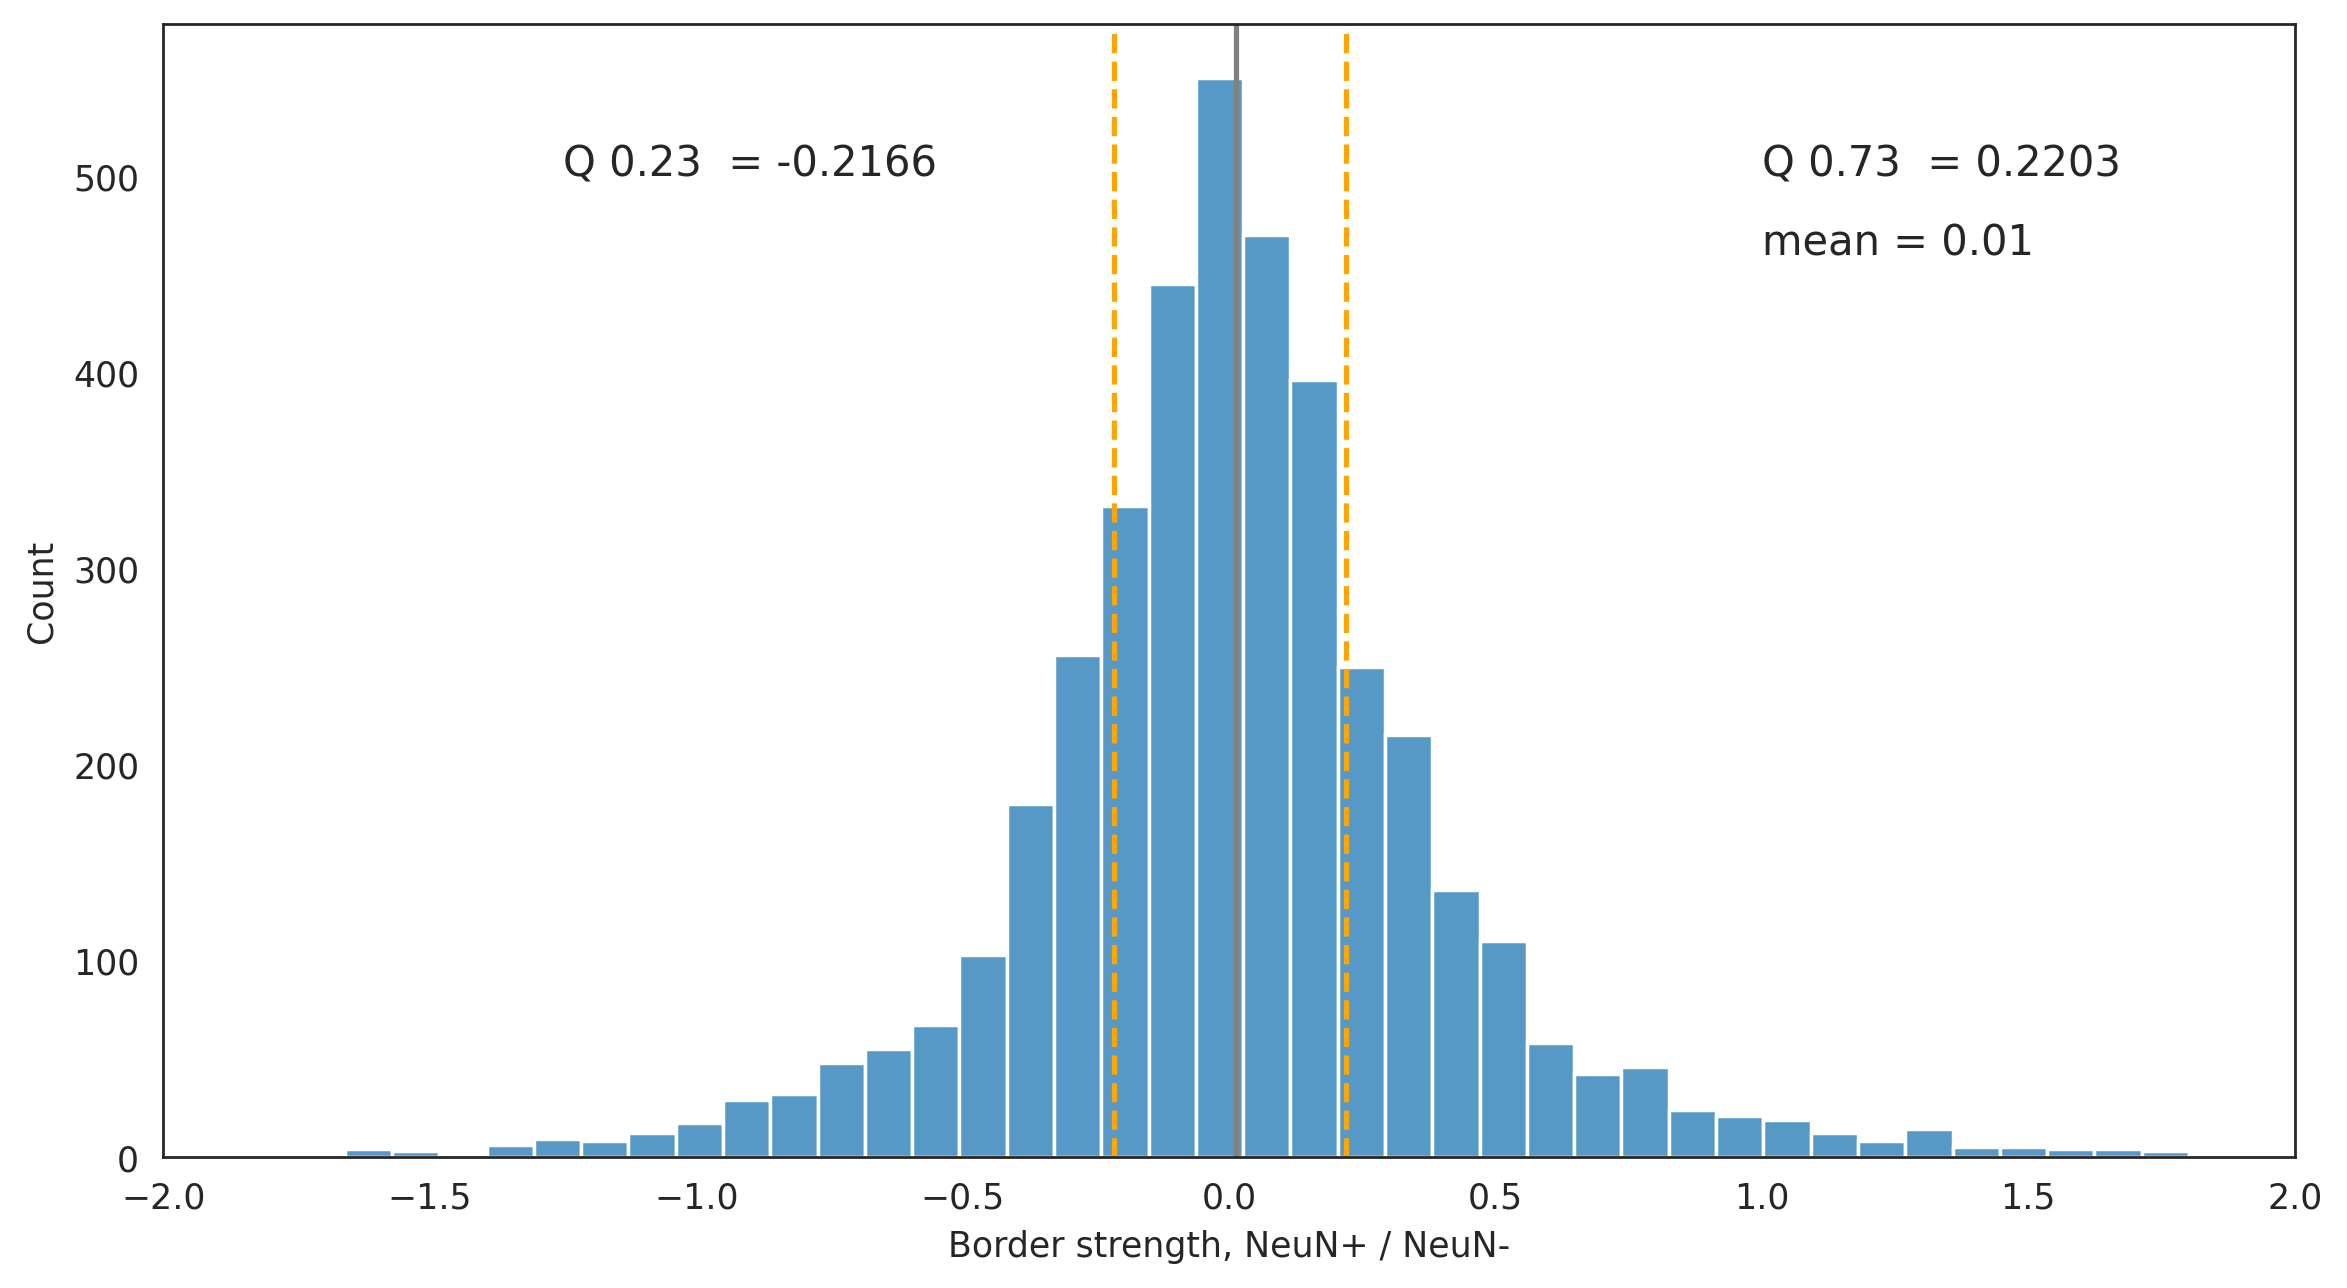

In [319]:
sns.set_style("white")
plt.figure(figsize=(11,6), dpi=250)
ax = sns.histplot(data=boundaries_common_15kb_120kb_params, x="bnd_strength_ratio", bins=50)
cnt=0
for i, q, num in zip(groups[[1,3]], [-1.25, 1], ["23", "73"]):
        plt.axvline(i,color='orange', linestyle='--')
        plt.text(q, 500, f'Q 0.{num}  = {round(i,4)}', fontsize = 12)
        cnt+=1
plt.xlim(-2,2)
plt.xlabel("Border strength, NeuN+ / NeuN-")
plt.axvline(np.mean(boundaries_common_15kb_120kb_params["bnd_strength_ratio"].tolist()),color='grey', linestyle='-')
plt.text(1, 500-20*cnt, f'mean = {round(np.mean(boundaries_common_15kb_120kb_params["bnd_strength_ratio"].tolist()),2)}', fontsize = 12)

In [69]:
boundaries_common_15kb_120kb_params_0 = boundaries_common_15kb_120kb_params[boundaries_common_15kb_120kb_params.bnd_strength_group.isin([0])]
boundaries_common_15kb_120kb_params_12 = boundaries_common_15kb_120kb_params[boundaries_common_15kb_120kb_params.bnd_strength_group.isin([1,2])]
boundaries_common_15kb_120kb_params_3 = boundaries_common_15kb_120kb_params[boundaries_common_15kb_120kb_params.bnd_strength_group.isin([3])]

In [70]:
status = []
for i in boundaries_plus.border_num1.tolist():
    if i in boundaries_plus_15kb_120kb_params.border_num1.tolist():
        status.append("neuronal")
    if i in boundaries_common_15kb_120kb_params_3.border_num1.tolist():
        status.append("neuronal")
    if i in boundaries_common_15kb_120kb_params_12.border_num1.tolist():
        status.append("common")
    if i in boundaries_common_15kb_120kb_params_0.border_num1.tolist():
        status.append("glial")
boundaries_plus["status"]  = status 

In [71]:
status = []
for i in boundaries_minus.border_num2.tolist():
    if i in boundaries_minus_15kb_120kb_params.border_num2.tolist():
        status.append("glial")
    if i in boundaries_common_15kb_120kb_params_3.border_num2.tolist():
        status.append("neuronal")
    if i in boundaries_common_15kb_120kb_params_12.border_num2.tolist():
        status.append("common")
    if i in boundaries_common_15kb_120kb_params_0.border_num2.tolist():
        status.append("glial")
boundaries_minus["status"]    = status 
boundaries_plus.columns = ["chrom","start","end", "f1","f2", "border_num1","status"]
boundaries_minus.columns = ["chrom","start","end", "f1","f2", "border_num1","status"]

boundaries_minus.to_csv("../data/boundaries_minus_annotaed.csv")
boundaries_plus.to_csv("../data/boundaries_plus_annotaed.csv")

#### Plot hic map for cell-specific borders

In [233]:
stacks_common = {}
names_border = ["boundaries_common", "boundaries_plus_unique", "boundaries_minus_unique"]
name = names_border[0]
common_for_hic1 = boundaries_plus[boundaries_plus.status.isin(["common"])][["chrom","start","end"]].reset_index(drop = True)
common_for_hic2 = boundaries_minus[boundaries_minus.status.isin(["common"])][["chrom","start","end"]].reset_index(drop = True)
files = [common_for_hic1, common_for_hic2]

stacks_common[name] = {}
stacks_list = []
for i, file in enumerate(files):
    stack = cooltools.pileup(clrs[i], 
                            file,
                         hg38_arms, 
                         expected_df=exps[i], 
                         flank = 120_000,
                         nproc=15)
    stack[:, :, np.all(stack == 0, axis=(0,1))] = np.nan
    stack = np.nanmean(stack, axis=2)
    stacks_list.append(stack)         
stacks_common[name] = stacks_list

In [291]:
names_border = ["boundaries_common", "boundaries_plus_unique", "boundaries_minus_unique"]
name = names_border[1]
common_for_hic1 = boundaries_plus[boundaries_plus.status.isin(["neuronal"])][["chrom","start","end"]].reset_index(drop = True)
files = [common_for_hic1, common_for_hic1]
stacks_common[name] = {}
stacks_list = []
for i, file in enumerate(files):
    stack = cooltools.pileup(clrs_10[i], 
                            file,
                         hg38_arms, 
                         expected_df=exps_10[i], 
                         flank = 120_000,
                         nproc=15)
    stack[:, :, np.all(stack == 0, axis=(0,1))] = np.nan
    stack = np.nanmean(stack, axis=2)
    stacks_list.append(stack)         
stacks_common[name] = stacks_list

In [292]:
names_border = ["boundaries_common", "boundaries_plus_unique", "boundaries_minus_unique"]
name = names_border[2]
common_for_hic2 = boundaries_minus[boundaries_minus.status.isin(["glial"])][["chrom","start","end"]].reset_index(drop = True)
files = [common_for_hic2, common_for_hic2]

stacks_common[name] = {}
stacks_list = []
for i, file in enumerate(files):
    stack = cooltools.pileup(clrs_10[i], 
                            file,
                         hg38_arms, 
                         expected_df=exps_10[i], 
                         flank = 120_000,
                         nproc=15)
    stack[:, :, np.all(stack == 0, axis=(0,1))] = np.nan
    stack = np.nanmean(stack, axis=2)
    stacks_list.append(stack)         
stacks_common[name] = stacks_list

<ipython-input-294-2bb62044b4fc>:13: RuntimeWarning: divide by zero encountered in log
  im = axs[i].imshow(np.log(div), cmap='coolwarm', vmin=vmin, vmax=vmax)
<ipython-input-294-2bb62044b4fc>:27: RuntimeWarning: invalid value encountered in true_divide
  div = file[0] / file[1]


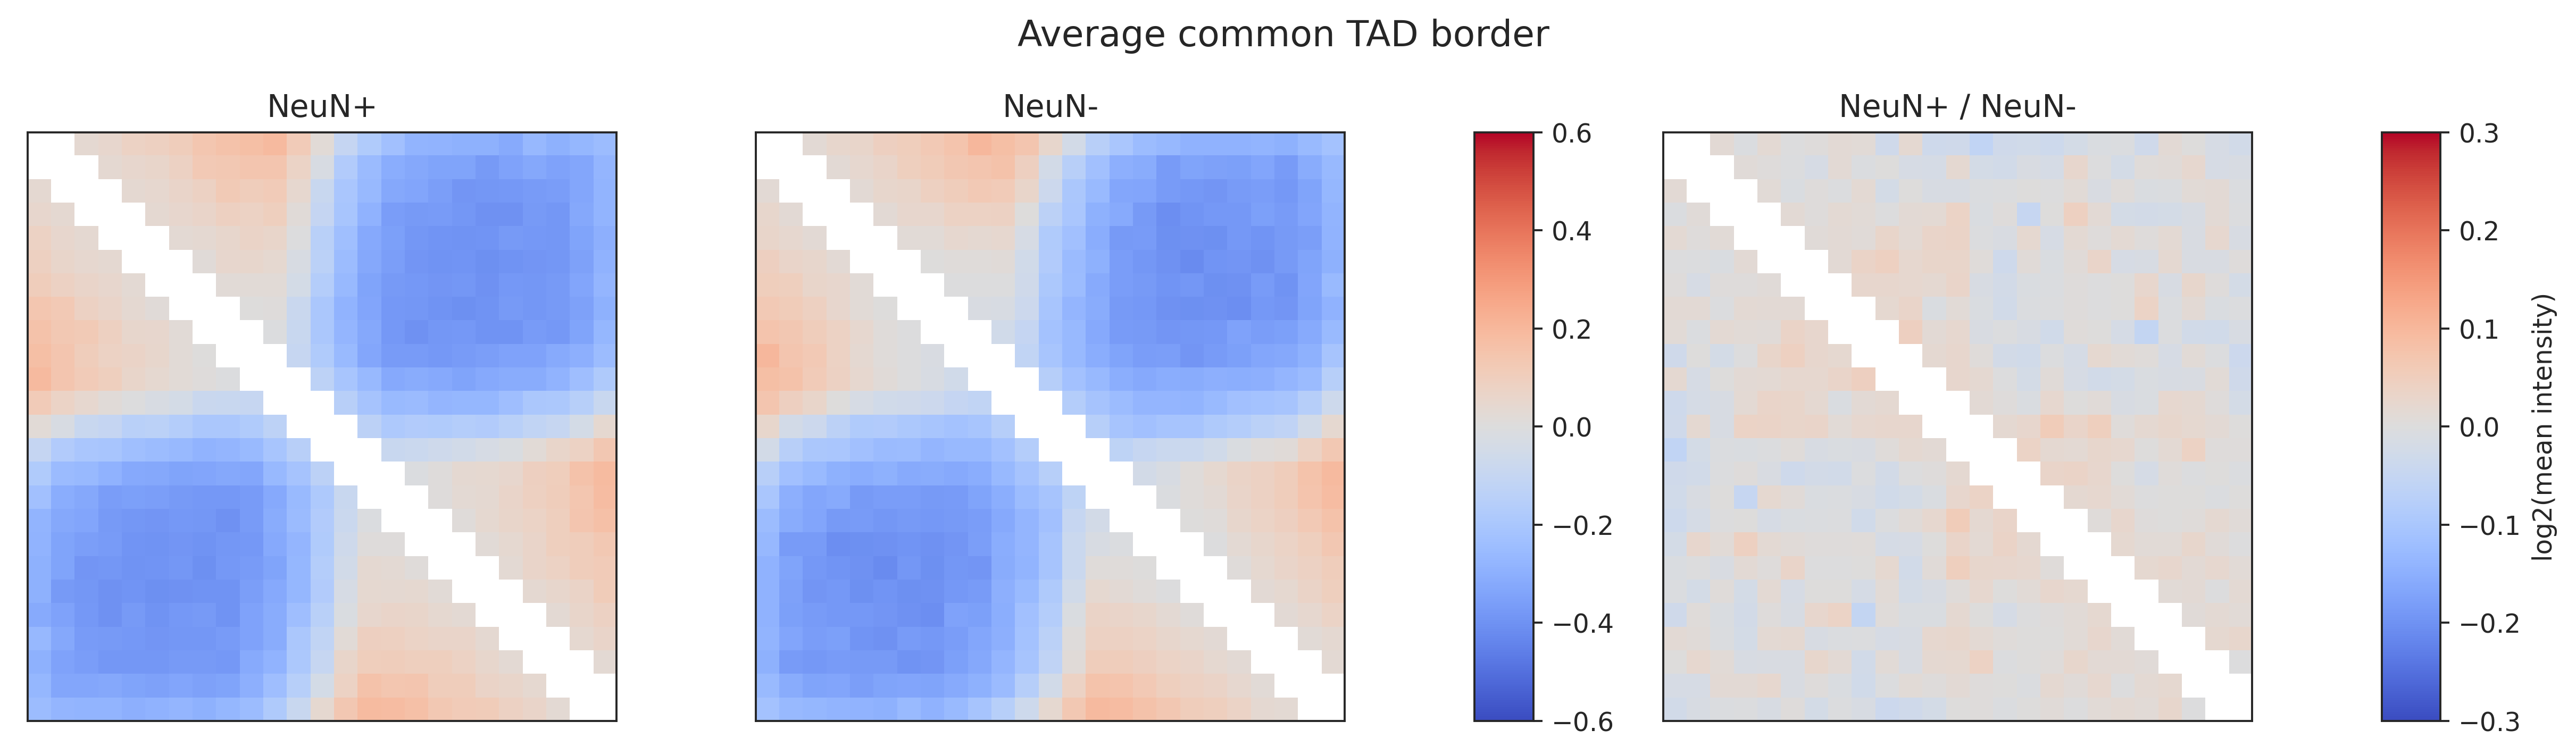

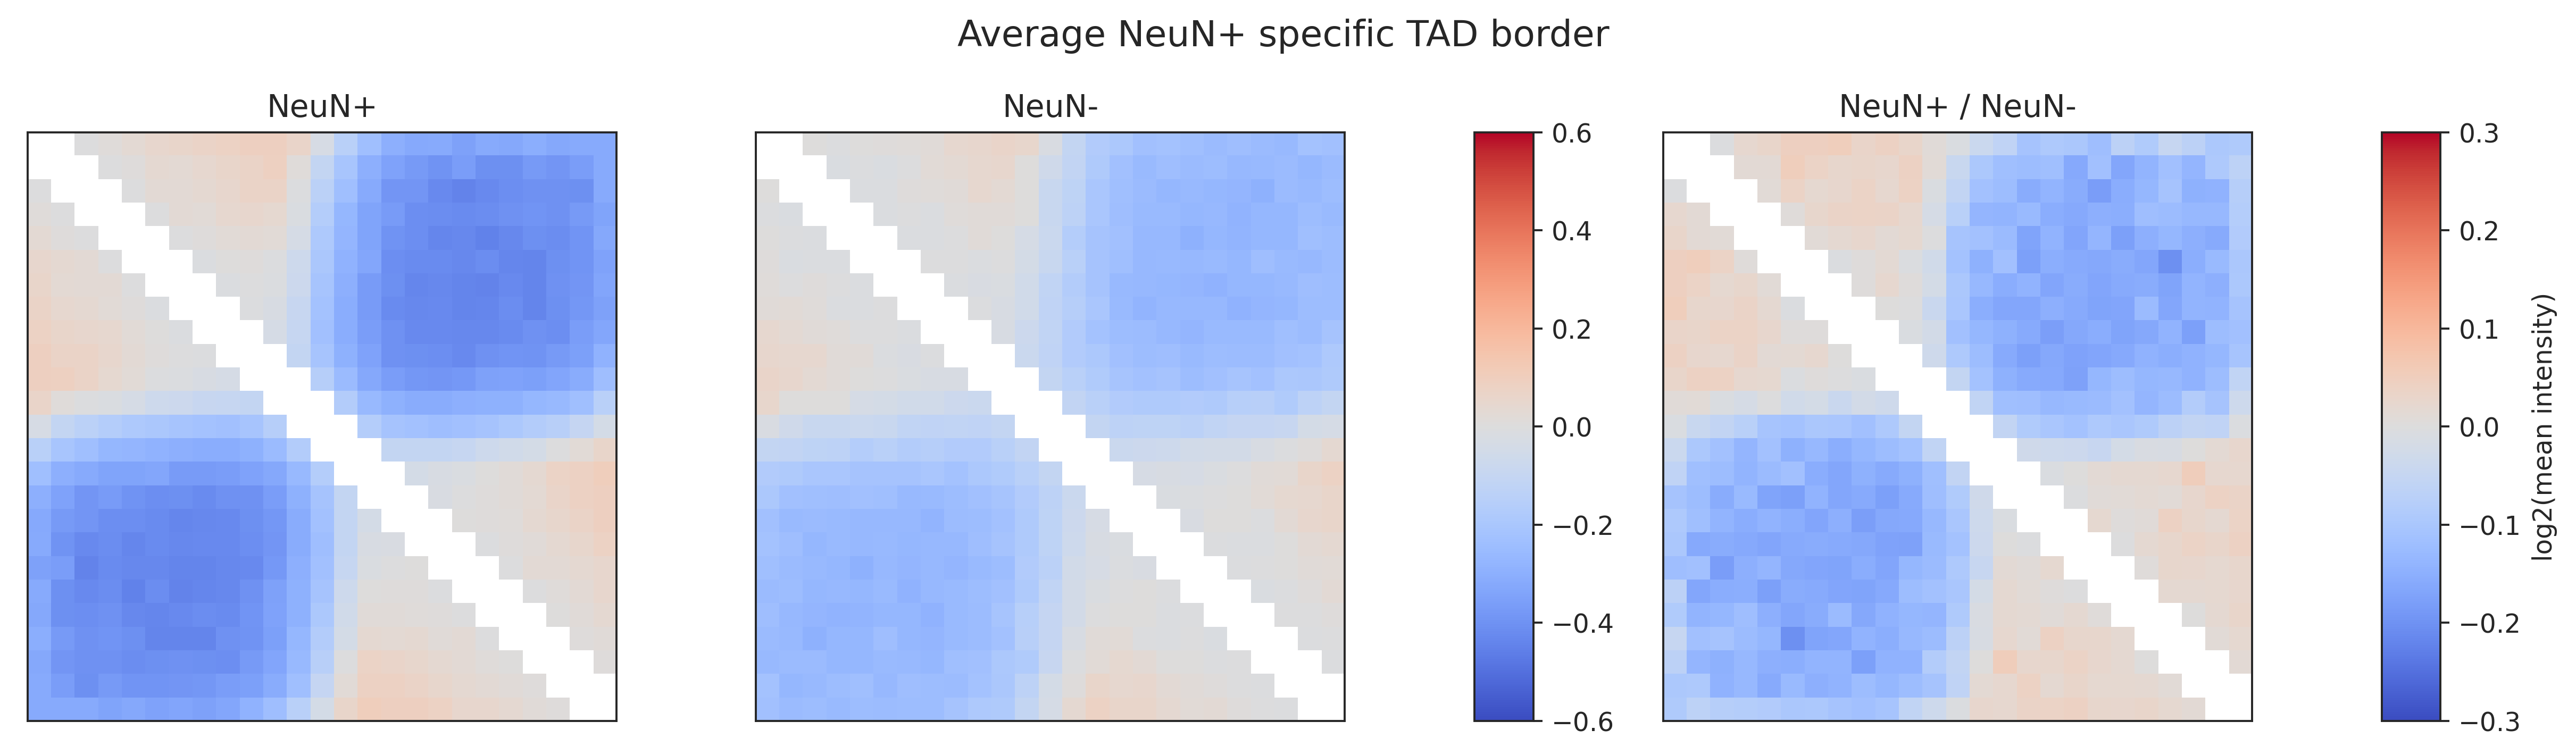

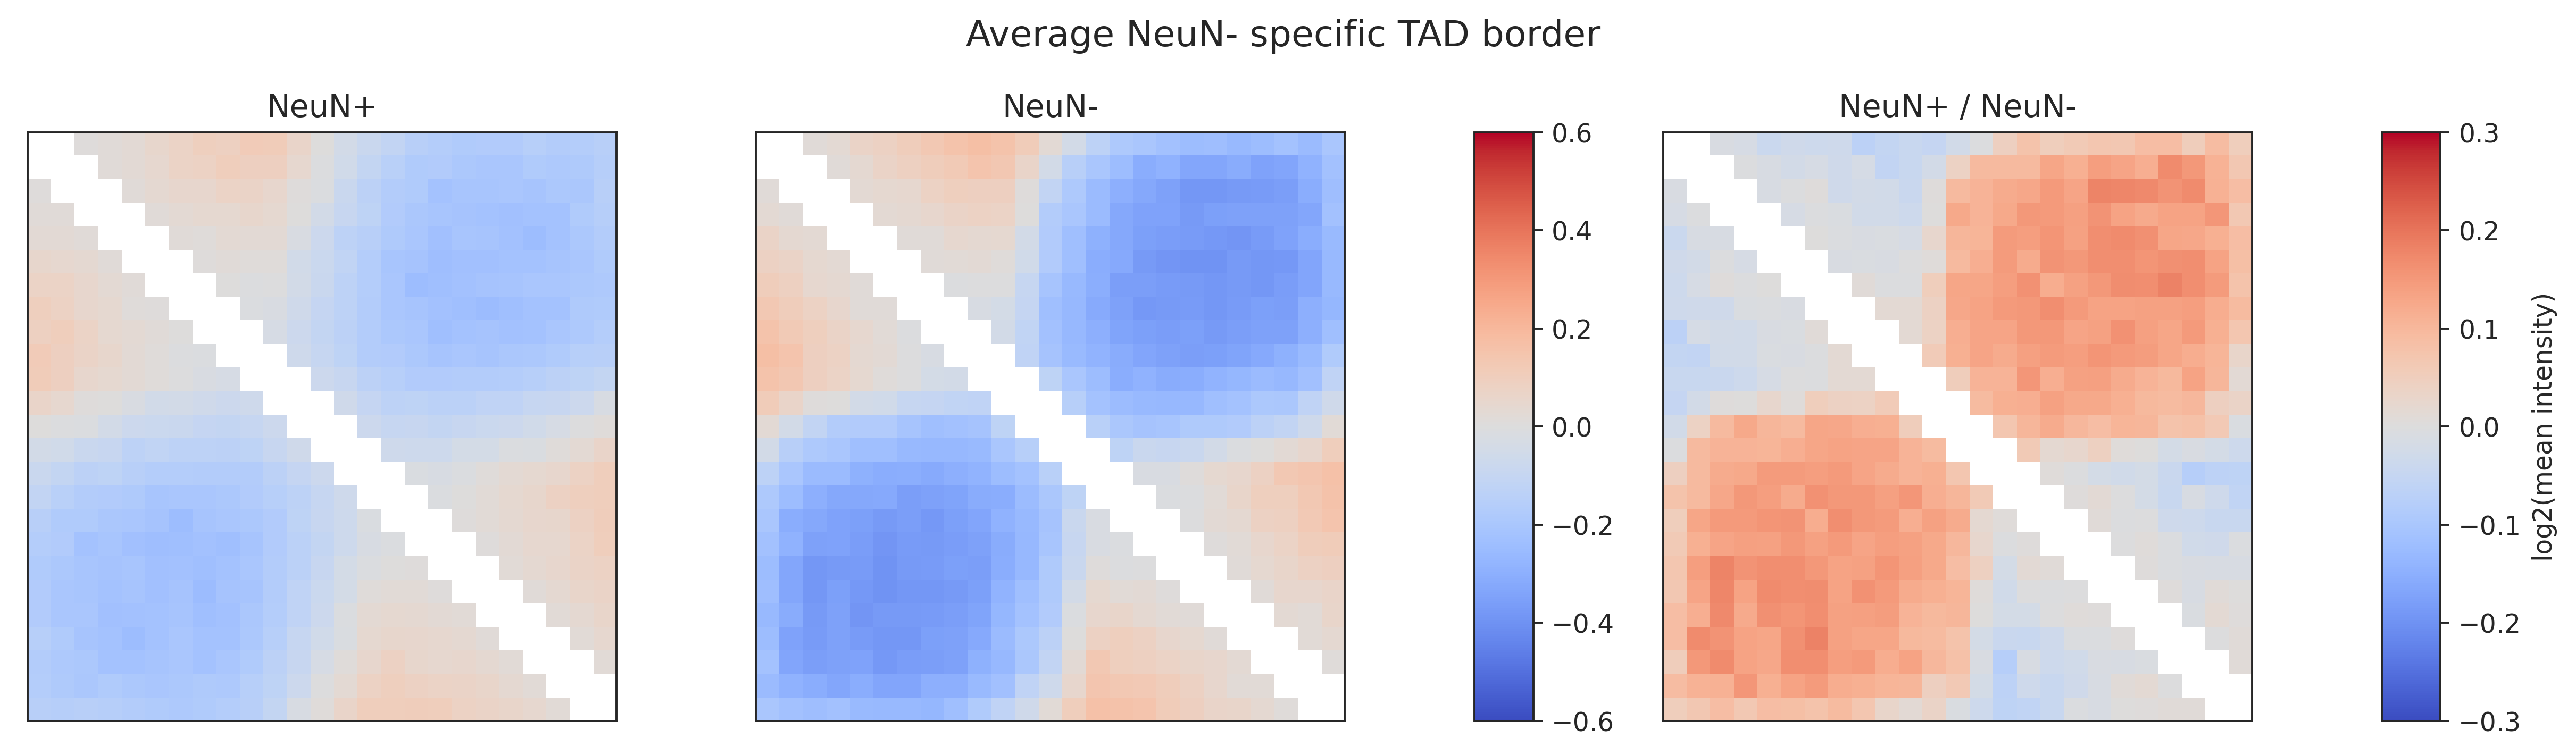

In [302]:
file_for_ploting = stacks_common
file_list = [boundaries_plus[boundaries_plus.status.isin(["common"])][["chrom","start","end"]], 
             common_for_hic1, 
             common_for_hic2]
names = ['common', 'NeuN+ specific', 'NeuN- specific']
for e, name in zip([0,1,2], names):    
    num = [file_list[e].shape[0], file_list[e].shape[0]]
    plot_tad_border_varied_scale(file_for_ploting[names_border[e]],num, name) 